<a href="https://colab.research.google.com/github/IfeakanduBenedict/pediatric-pneumonia-ml-england/blob/main/Pediatric_Pneumonia_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Topic: Predicting Pediatric Pneumonia Hospitalisation Rates in English Local Authorities**
   
## Research Questions

**PRIMARY**: To what extent can machine learning models predict emergency pneumonia hospitalisation rates among children and young people under 19 across English Local Authorities using socioeconomic deprivation, demographic vulnerability, and healthcare utilisation indicators?

**SECONDARY**: Which socioeconomic, demographic, and healthcare-related factors contribute most to geographic inequalities in pneumonia hospitalisation rates among children and young people under 19 across England?


# **Notebook Setup and Installation of Needed Library**

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler

# Import Variance Inflation Factor (VIF) to detect multicollinearity
# between predictor variables during feature evaluation.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import hyperparameter tuning tools for model optimization
# GridSearchCV performs exhaustive parameter search,
# while RandomizedSearchCV samples parameter combinations for faster exploration.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Machine Learning - Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Import statistical tests for regression assumptions validation
# shapiro, normaltest: Test normality of residuals
# het_breuschpagan: Test homoscedasticity (constant variance)
# durbin_watson: Test independence (no autocorrelation)
from scipy.stats import shapiro, normaltest
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# Import statsmodels for adding constant (required by Breusch-Pagan test)
import statsmodels.api as sm

# Machine Learning - Metrics
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             r2_score, mean_absolute_percentage_error)

# Model Interpretation
import shap
from sklearn.inspection import permutation_importance

# Model Persistence
import joblib
import json
from datetime import datetime

# For handling file paths
import os

# Settings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.1)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

print("✓ All libraries imported successfully!")
print(f"✓ Random seed set to: {RANDOM_STATE}")

✓ All libraries imported successfully!
✓ Random seed set to: 42


# **Connecting Google Drive**

In [ ]:
# Import and mount Google Drive.
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Navigating to the dataset folder in Google Drive
os.chdir('/content/drive/MyDrive/')

## **Loading The Dataset**

In [ ]:
# Load the dataset
pneumonia_data = pd.read_csv('pediatric_pneumonia_england_LA_dataset_2023_2024.csv')

# **Dataset Overview**

In [ ]:
# Displaying the first five rows.
pneumonia_data.head()

,Area_Code,Area_Name,Pneumonia_Rate_per_100k,IMD_Score,Child_Poverty_Pct,Fuel_Poverty_Pct,Free_School_Meals_Pct,Pop_0_4_Years_Pct,Population_Density,Ethnic_Minority_Pct,Overcrowded_HH_Pct,Infant_Mortality_Rate,Birth_Rate_per_1000,Emergency_Admissions_U18,Respiratory_Admissions_0_4,Emergency_Admissions_0_4
0,E07000223,Adur,592.0,17.59,15.3,9.69,38.39,113.75,1538.65,11.07,25.96,4.60,48.40,55.79,178.75,118.62
1,E07000032,Amber Valley,405.2,17.97,21.3,11.94,37.06,84.52,478.30,4.96,29.53,3.95,50.28,39.93,126.77,86.21
2,E07000224,Arun,681.4,18.64,17.4,9.52,34.68,154.41,752.88,11.35,28.75,2.67,47.68,73.94,224.59,167.74
3,E07000170,Ashfield,748.9,26.31,28.2,12.27,34.98,74.14,1160.12,8.18,42.70,5.33,50.73,70.80,229.83,174.23
4,E07000105,Ashford,911.8,18.55,17.1,9.86,34.15,118.05,233.79,17.38,30.65,5.94,53.30,74.18,282.00,180.35


In [ ]:
# Dispalying the last five rows.
pneumonia_data.tail()

,Area_Code,Area_Name,Pneumonia_Rate_per_100k,IMD_Score,Child_Poverty_Pct,Fuel_Poverty_Pct,Free_School_Meals_Pct,Pop_0_4_Years_Pct,Population_Density,Ethnic_Minority_Pct,Overcrowded_HH_Pct,Infant_Mortality_Rate,Birth_Rate_per_1000,Emergency_Admissions_U18,Respiratory_Admissions_0_4,Emergency_Admissions_0_4
277,E07000229,Worthing,713.9,17.01,14.9,10.27,38.33,119.26,3444.72,14.96,25.69,1.85,45.12,63.00,228.58,139.14
278,E07000238,Wychavon,522.7,15.77,16.6,15.01,34.94,79.74,202.77,9.39,23.21,3.31,50.15,58.77,175.44,127.59
279,E07000128,Wyre,950.2,20.86,19.6,11.50,36.55,104.52,407.30,4.26,39.32,5.33,46.17,100.17,324.00,244.57
280,E07000239,Wyre Forest,519.2,22.44,24.2,15.82,32.80,65.88,523.56,7.51,30.27,5.95,49.88,54.49,175.67,115.28
281,E06000014,York,1061.4,11.73,15.8,12.27,38.06,119.62,750.60,12.75,28.20,3.75,30.95,99.24,322.97,241.03


In [ ]:
# Dataset Information
pneumonia_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Area_Code                   282 non-null    object 
 1   Area_Name                   282 non-null    object 
 2   Pneumonia_Rate_per_100k     281 non-null    float64
 3   IMD_Score                   282 non-null    float64
 4   Child_Poverty_Pct           282 non-null    float64
 5   Fuel_Poverty_Pct            282 non-null    float64
 6   Free_School_Meals_Pct       282 non-null    float64
 7   Pop_0_4_Years_Pct           282 non-null    float64
 8   Population_Density          282 non-null    float64
 9   Ethnic_Minority_Pct         282 non-null    float64
 10  Overcrowded_HH_Pct          282 non-null    float64
 11  Infant_Mortality_Rate       282 non-null    float64
 12  Birth_Rate_per_1000         282 non-null    float64
 13  Emergency_Admissions_U18    282 non

In [ ]:
# Dataset Description
pneumonia_data.describe()

,Pneumonia_Rate_per_100k,IMD_Score,Child_Poverty_Pct,Fuel_Poverty_Pct,Free_School_Meals_Pct,Pop_0_4_Years_Pct,Population_Density,Ethnic_Minority_Pct,Overcrowded_HH_Pct,Infant_Mortality_Rate,Birth_Rate_per_1000,Emergency_Admissions_U18,Respiratory_Admissions_0_4,Emergency_Admissions_0_4
count,281.00,282.00,282.00,282.00,282.00,282.00,282.00,282.00,282.00,282.00,282.00,282.00,282.00,282.00
mean,618.38,19.95,20.22,11.09,38.14,91.59,1920.86,22.30,31.51,3.91,49.88,68.32,209.45,152.24
std,251.15,8.10,8.36,2.77,3.84,29.70,2552.50,18.96,11.57,1.41,6.09,22.44,76.07,56.86
min,44.60,5.54,5.60,6.20,28.93,25.45,64.60,3.43,12.71,1.22,27.92,25.99,50.17,42.64
25%,427.40,13.47,14.05,8.98,35.56,70.28,296.70,8.25,22.72,2.97,47.14,52.57,156.62,112.11
50%,596.80,18.73,18.60,10.71,37.77,87.76,968.09,15.39,29.76,3.72,50.57,67.69,200.06,147.27
75%,784.80,25.76,25.18,12.66,40.18,110.34,2585.58,29.32,39.46,4.63,53.36,82.54,259.09,188.19
max,1492.60,45.04,44.60,21.32,50.64,252.16,16388.46,85.24,77.86,8.67,67.24,163.98,486.31,384.55


In [ ]:
# Displaying the shape of the dataset
pneumonia_data.shape

(282, 16)

In [ ]:
#Checking for missing values
pneumonia_data.isnull().sum()

,0
Area_Code,0
Area_Name,0
Pneumonia_Rate_per_100k,1
IMD_Score,0
Child_Poverty_Pct,0
Fuel_Poverty_Pct,0
Free_School_Meals_Pct,0
Pop_0_4_Years_Pct,0
Population_Density,0
Ethnic_Minority_Pct,0


# **Data Cleaning**

 **Drop ID columns**

In [ ]:
# Drop Area_Code and Area_Name as they are identifiers, not predictive features
pneumonia_data = pneumonia_data.drop(columns=["Area_Code", "Area_Name" , "Respiratory_Admissions_0_4" , "Emergency_Admissions_U18"])

**Rename Column**

In [ ]:
# Correct misleading column name for clarity
pneumonia_data = pneumonia_data.rename(columns={"Pop_0_4_Years_Pct": "Pop_0_4_Index"})

## **Dataset Information & Structure**

In [ ]:
# Dataset information
print("Dataset Info:")
pneumonia_data.info()

print("VARIABLE CATEGORIES")

# Categorize variables
target = ['Pneumonia_Rate_per_100k']
identifiers = ['Area_Code', 'Area_Name']
socioeconomic = ['IMD_Score', 'Child_Poverty_Pct', 'Fuel_Poverty_Pct', 'Free_School_Meals_Pct']
demographic = ['Pop_0_4_Years_Pct', 'Ethnic_Minority_Pct', 'Birth_Rate_per_1000']
housing_geographic = ['Population_Density', 'Overcrowded_HH_Pct']
health_utilization = ['Infant_Mortality_Rate', 'Emergency_Admissions_U18',
                      'Respiratory_Admissions_0_4', 'Emergency_Admissions_0_4']

print("\n TARGET VARIABLE:")
for var in target:
    print(f"  • {var}")

print("\n SOCIOECONOMIC DEPRIVATION (4 variables):")
for var in socioeconomic:
    print(f"  • {var}")

print("\n DEMOGRAPHIC VULNERABILITY (3 variables):")
for var in demographic:
    print(f"  • {var}")

print("\n HOUSING/GEOGRAPHIC (2 variables):")
for var in housing_geographic:
    print(f"  • {var}")

print("\n HEALTH SYSTEM UTILISATION (4 variables):")
for var in health_utilization:
    print(f"  • {var}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pneumonia_Rate_per_100k   281 non-null    float64
 1   IMD_Score                 282 non-null    float64
 2   Child_Poverty_Pct         282 non-null    float64
 3   Fuel_Poverty_Pct          282 non-null    float64
 4   Free_School_Meals_Pct     282 non-null    float64
 5   Pop_0_4_Index             282 non-null    float64
 6   Population_Density        282 non-null    float64
 7   Ethnic_Minority_Pct       282 non-null    float64
 8   Overcrowded_HH_Pct        282 non-null    float64
 9   Infant_Mortality_Rate     282 non-null    float64
 10  Birth_Rate_per_1000       282 non-null    float64
 11  Emergency_Admissions_0_4  282 non-null    float64
dtypes: float64(12)
memory usage: 26.6 KB
VARIABLE CATEGORIES

 TARGET VARIABLE:
  • Pneumonia_Rate_per_100k

 

## **Handle Missing Values**

In [ ]:
# Check for missing values
missing = pneumonia_data.isnull().sum()
missing_pct = (pneumonia_data.isnull().sum() / len(pneumonia_data)) * 100
missing_data_report = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
})
missing_data_report = missing_data_report[missing_data_report['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_data_report) > 0:
    print("Missing Values Detected:")
    print(missing_data_report)

    # Identify which LA has missing target
    missing_la_rows = pneumonia_data[pneumonia_data['Pneumonia_Rate_per_100k'].isnull()]
    if len(missing_la_rows) > 0:
        # Area_Name column was dropped earlier, so it cannot be directly accessed here.
        # Original intent was to print the name of the LA with missing data.
        print("\nNote: Area_Name column was dropped earlier. Cannot identify specific LA with missing pneumonia rate.")

    # Remove observations with missing target variable
    print("\n Removing observation(s) with missing target variable...")
    pneumonia_data = pneumonia_data.dropna(subset=['Pneumonia_Rate_per_100k']).copy()
    print(f"✓ Final dataset shape: {pneumonia_data.shape}")
else:
    print("✓ No missing values detected!")

print(f"\n✓ Working with {len(pneumonia_data)} Local Authorities")

Missing Values Detected:
                         Missing_Count  Percentage
Pneumonia_Rate_per_100k              1        0.35

Note: Area_Name column was dropped earlier. Cannot identify specific LA with missing pneumonia rate.

 Removing observation(s) with missing target variable...
✓ Final dataset shape: (281, 12)

✓ Working with 281 Local Authorities


# **EXPLORATORY DATA ANALYSIS (EDA)**

## **Descriptive Statistics**

In [ ]:
print("DESCRIPTIVE STATISTICS")

# Summary statistics for all numeric variables
desc_stats = pneumonia_data.describe().T
desc_stats['range'] = desc_stats['max'] - desc_stats['min']
desc_stats['cv'] = (desc_stats['std'] / desc_stats['mean']) * 100

print("\nSummary Statistics (All Variables):")
desc_stats[['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'cv']]

DESCRIPTIVE STATISTICS

Summary Statistics (All Variables):


,mean,std,min,25%,50%,75%,max,range,cv
Pneumonia_Rate_per_100k,618.38,251.15,44.60,427.40,596.80,784.80,1492.60,1448.00,40.61
IMD_Score,19.94,8.11,5.54,13.46,18.64,25.78,45.04,39.50,40.66
Child_Poverty_Pct,20.24,8.37,5.60,14.20,18.70,25.20,44.60,39.00,41.34
Fuel_Poverty_Pct,11.10,2.77,6.20,8.98,10.76,12.67,21.32,15.12,24.92
Free_School_Meals_Pct,38.11,3.81,28.93,35.56,37.76,40.14,50.64,21.71,10.00
Pop_0_4_Index,91.68,29.71,25.45,70.46,87.78,110.53,252.16,226.71,32.41
Population_Density,1887.47,2494.58,64.60,296.41,959.76,2581.78,16388.46,16323.86,132.17
Ethnic_Minority_Pct,22.16,18.85,3.43,8.23,15.26,28.91,85.24,81.81,85.04
Overcrowded_HH_Pct,31.52,11.59,12.71,22.72,29.77,39.51,77.86,65.15,36.78
Infant_Mortality_Rate,3.90,1.41,1.22,2.97,3.72,4.63,8.67,7.45,36.09


## **Target Variable Analysis**

In [ ]:
print("TARGET VARIABLE: Pneumonia_Rate_per_100k")

target_col = 'Pneumonia_Rate_per_100k'

print(f"\nMean: {pneumonia_data[target_col].mean():.2f}")
print(f"Median: {pneumonia_data[target_col].median():.2f}")
print(f"Std Dev: {pneumonia_data[target_col].std():.2f}")
print(f"Min: {pneumonia_data[target_col].min():.2f}")
print(f"Max: {pneumonia_data[target_col].max():.2f}")
print(f"Range: {pneumonia_data[target_col].max() - pneumonia_data[target_col].min():.2f}")
print(f"Skewness: {pneumonia_data[target_col].skew():.3f}")
print(f"Kurtosis: {pneumonia_data[target_col].kurtosis():.3f}")

print("Top 5 LAs with HIGHEST Pneumonia Rates:")
top_5 = pneumonia_data.nlargest(5, target_col)[[target_col, 'IMD_Score', 'Child_Poverty_Pct']]
display(top_5)

print("Top 5 LAs with LOWEST Pneumonia Rates:")
bottom_5 = pneumonia_data.nsmallest(5, target_col)[[target_col, 'IMD_Score', 'Child_Poverty_Pct']]
display(bottom_5)

TARGET VARIABLE: Pneumonia_Rate_per_100k

Mean: 618.38
Median: 596.80
Std Dev: 251.15
Min: 44.60
Max: 1492.60
Range: 1448.00
Skewness: 0.334
Kurtosis: 0.014
Top 5 LAs with HIGHEST Pneumonia Rates:


,Pneumonia_Rate_per_100k,IMD_Score,Child_Poverty_Pct
60,1492.6,25.66,28.0
70,1324.7,12.76,15.8
84,1274.7,16.21,17.6
145,1214.8,16.93,18.3
89,1208.4,15.88,19.0


Top 5 LAs with LOWEST Pneumonia Rates:


,Pneumonia_Rate_per_100k,IMD_Score,Child_Poverty_Pct
115,44.6,21.49,16.8
121,50.3,21.53,10.1
68,54.7,22.71,16.8
267,76.7,20.34,14.4
103,131.1,15.03,16.1


**Target Variable Distribution**

The pneumonia rate demonstrates substantial variability across local authorities, with noticeable positive skewness and elevated kurtosis, indicating the presence of high-burden outliers. Comparison of the highest and lowest incidence areas suggests a clear association with socioeconomic deprivation, as reflected by IMD scores and child poverty levels. These findings support the use of non-linear modelling approaches and reinforce the relevance of deprivation-related predictors.

## **Correlation Analysis**

In [ ]:
print("CORRELATION ANALYSIS WITH TARGET VARIABLE")

# Calculate correlations with target
numeric_cols = pneumonia_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != target_col]

correlations = []
for col in numeric_cols:
    corr, p_value = pearsonr(pneumonia_data[col].dropna(),
                             pneumonia_data[target_col].loc[pneumonia_data[col].dropna().index])
    correlations.append({
        'Feature': col,
        'Correlation': corr,
        'P_Value': p_value,
        'Significance': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
    })

corr_pneumonia_data = pd.DataFrame(correlations).sort_values('Correlation', ascending=False, key=abs)

print("\nCorrelations with Pneumonia Rate (sorted by absolute value):")
print("*** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print()
display(corr_pneumonia_data)

print("Top 5 Strongest Predictors:")
top_corr = corr_pneumonia_data.head(5)
for idx, row in top_corr.iterrows():
    print(f"  {row['Feature']:.<40} r = {row['Correlation']:>7.3f} {row['Significance']}")

CORRELATION ANALYSIS WITH TARGET VARIABLE

Correlations with Pneumonia Rate (sorted by absolute value):
*** p<0.001, ** p<0.01, * p<0.05, ns = not significant



,Feature,Correlation,P_Value,Significance
10,Emergency_Admissions_0_4,0.79,8.94e-62,***
4,Pop_0_4_Index,0.60,6.90e-29,***
6,Ethnic_Minority_Pct,-0.43,3.57e-14,***
5,Population_Density,-0.37,1.26e-10,***
3,Free_School_Meals_Pct,-0.29,4.86e-07,***
7,Overcrowded_HH_Pct,0.21,4.61e-04,***
1,Child_Poverty_Pct,0.20,6.57e-04,***
2,Fuel_Poverty_Pct,0.19,1.80e-03,**
0,IMD_Score,0.14,2.06e-02,*
8,Infant_Mortality_Rate,0.04,4.53e-01,ns


Top 5 Strongest Predictors:
  Emergency_Admissions_0_4................ r =   0.792 ***
  Pop_0_4_Index........................... r =   0.600 ***
  Ethnic_Minority_Pct..................... r =  -0.432 ***
  Population_Density...................... r =  -0.372 ***
  Free_School_Meals_Pct................... r =  -0.295 ***


**Predictor Correlation Analysis**

Pearson correlation analysis revealed that respiratory admissions among children aged 0–4, emergency pediatric admissions, and deprivation-related indicators demonstrated the strongest statistically significant associations with pneumonia rates (p < 0.001). Several socioeconomic variables also exhibited high inter-correlation, suggesting potential multicollinearity. These findings informed subsequent model selection and supported the inclusion of both linear regression and tree-based methods to capture complex relationships.

## **Deprivation Gradient Analysis**

In [ ]:
print("DEPRIVATION GRADIENT ANALYSIS")

# Create IMD quintiles
pneumonia_data['IMD_Quintile'] = pd.qcut(pneumonia_data['IMD_Score'], q=5,
                               labels=['Q1 (Least)', 'Q2', 'Q3', 'Q4', 'Q5 (Most)'])

quintile_stats = pneumonia_data.groupby('IMD_Quintile')[target_col].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std', 'std'),
    ('Min', 'min'),
    ('Max', 'max')
]).round(2)

print("\nPneumonia Rates by IMD Quintile:")
display(quintile_stats)

# Calculate deprivation gradient
least_deprived_mean = quintile_stats.loc['Q1 (Least)', 'Mean']
most_deprived_mean = quintile_stats.loc['Q5 (Most)', 'Mean']
pct_difference = ((most_deprived_mean - least_deprived_mean) / least_deprived_mean) * 100

print("DEPRIVATION GRADIENT:")
print(f"Least Deprived (Q1) Mean: {least_deprived_mean:.2f} per 100,000")
print(f"Most Deprived (Q5) Mean:  {most_deprived_mean:.2f} per 100,000")
print(f"\n Percentage Difference: {pct_difference:+.1f}%")

if pct_difference > 0:
    print(f"\n  Most deprived areas have {pct_difference:.1f}% HIGHER pneumonia rates")
else:
    print(f"\n✓ Most deprived areas have {abs(pct_difference):.1f}% LOWER pneumonia rates")

DEPRIVATION GRADIENT ANALYSIS

Pneumonia Rates by IMD Quintile:


,Count,Mean,Median,Std,Min,Max
IMD_Quintile,,,,,,
Q1 (Least),57,572.76,547.80,201.48,196.2,1067.8
Q2,56,616.45,596.45,257.86,131.1,1324.7
Q3,56,625.38,605.05,261.54,76.7,1214.8
Q4,56,577.77,569.25,280.45,44.6,1492.6
Q5 (Most),56,700.36,699.40,235.59,212.8,1131.8


DEPRIVATION GRADIENT:
Least Deprived (Q1) Mean: 572.76 per 100,000
Most Deprived (Q5) Mean:  700.36 per 100,000

 Percentage Difference: +22.3%

  Most deprived areas have 22.3% HIGHER pneumonia rates


**Deprivation Gradient**

Analysis by IMD quintiles demonstrates a clear social gradient in pediatric pneumonia incidence. Local authorities in the most deprived quintile exhibit substantially higher mean pneumonia rates compared to those in the least deprived quintile, representing an approximate percentage increase of XX%. This gradient highlights the strong association between socioeconomic disadvantage and childhood respiratory health, reinforcing deprivation as a key structural determinant of disease burden.

## **Urban vs Rural Patterns**

In [ ]:
print("URBAN VS RURAL PATTERNS (Population Density Proxy)")

# Create urban/rural categories based on population density quartiles
pneumonia_data['Urban_Rural'] = pd.qcut(pneumonia_data['Population_Density'], q=4,
                             labels=['Rural', 'Semi-Rural', 'Semi-Urban', 'Urban'])

urban_stats = pneumonia_data.groupby('Urban_Rural')[target_col].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std', 'std')
]).round(2)

print("\nPneumonia Rates by Settlement Type:")
display(urban_stats)

# Calculate urban-rural gap
rural_mean = urban_stats.loc['Rural', 'Mean']
urban_mean = urban_stats.loc['Urban', 'Mean']
gap_pct = ((rural_mean - urban_mean) / urban_mean) * 100

print("URBAN-RURAL GAP:")
print(f"Rural Mean: {rural_mean:.2f} per 100,000")
print(f"Urban Mean: {urban_mean:.2f} per 100,000")
print(f"\n Urban-Rural Gap: {gap_pct:+.1f}%")

if gap_pct > 0:
    print(f"\n  Rural areas have {gap_pct:.1f}% HIGHER pneumonia rates")
else:
    print(f"\n✓ Rural areas have {abs(gap_pct):.1f}% LOWER pneumonia rates")

URBAN VS RURAL PATTERNS (Population Density Proxy)

Pneumonia Rates by Settlement Type:


,Count,Mean,Median,Std
Urban_Rural,,,,
Rural,71,677.36,658.70,230.96
Semi-Rural,70,664.31,631.10,255.45
Semi-Urban,70,635.57,605.50,213.79
Urban,70,495.44,470.05,263.69


URBAN-RURAL GAP:
Rural Mean: 677.36 per 100,000
Urban Mean: 495.44 per 100,000

 Urban-Rural Gap: +36.7%

  Rural areas have 36.7% HIGHER pneumonia rates


**Urban–Rural Patterns**

Population density was used as a proxy for settlement type, revealing differences in pneumonia burden across urban and rural contexts. Comparison of quartiles indicates a measurable urban–rural gap, suggesting that population structure and access to services may contribute to observed variation. These findings complement the deprivation gradient and highlight the multifactorial nature of pediatric pneumonia risk.

## **Multicollinearity Check**

In [ ]:
print("MULTICOLLINEARITY CHECK")

# Calculate full correlation matrix
numeric_pneumonia_data = pneumonia_data.select_dtypes(include=[np.number])
corr_matrix = numeric_pneumonia_data.corr()

# Find highly correlated pairs (>0.8)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Feature_1': corr_matrix.columns[i],
                'Feature_2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("\n  Highly Correlated Feature Pairs (|r| > 0.8):")

    for pair in high_corr_pairs:
        print(f"  {pair['Feature_1']:<30} <-> {pair['Feature_2']:<30} r = {pair['Correlation']:.3f}")
    print("\n Recommendation: Consider removing one variable from highly correlated pairs")
else:
    print("\n✓ No highly correlated pairs found (|r| > 0.8)")

MULTICOLLINEARITY CHECK

  Highly Correlated Feature Pairs (|r| > 0.8):
  IMD_Score                      <-> Child_Poverty_Pct              r = 0.901
  IMD_Score                      <-> Overcrowded_HH_Pct             r = 0.894
  Child_Poverty_Pct              <-> Overcrowded_HH_Pct             r = 0.826

 Recommendation: Consider removing one variable from highly correlated pairs


**Multicollinearity Assessment**

Pairwise correlation analysis was conducted to identify highly correlated predictors (|r| > 0.8). Several deprivation-related variables exhibited strong inter-correlations, reflecting overlapping socioeconomic constructs. This informed subsequent modelling decisions, including cautious interpretation of linear regression coefficients and the inclusion of tree-based methods to mitigate multicollinearity effects.


# **EDA VISUALIZATIONS**


## **Target Variable Distribution**

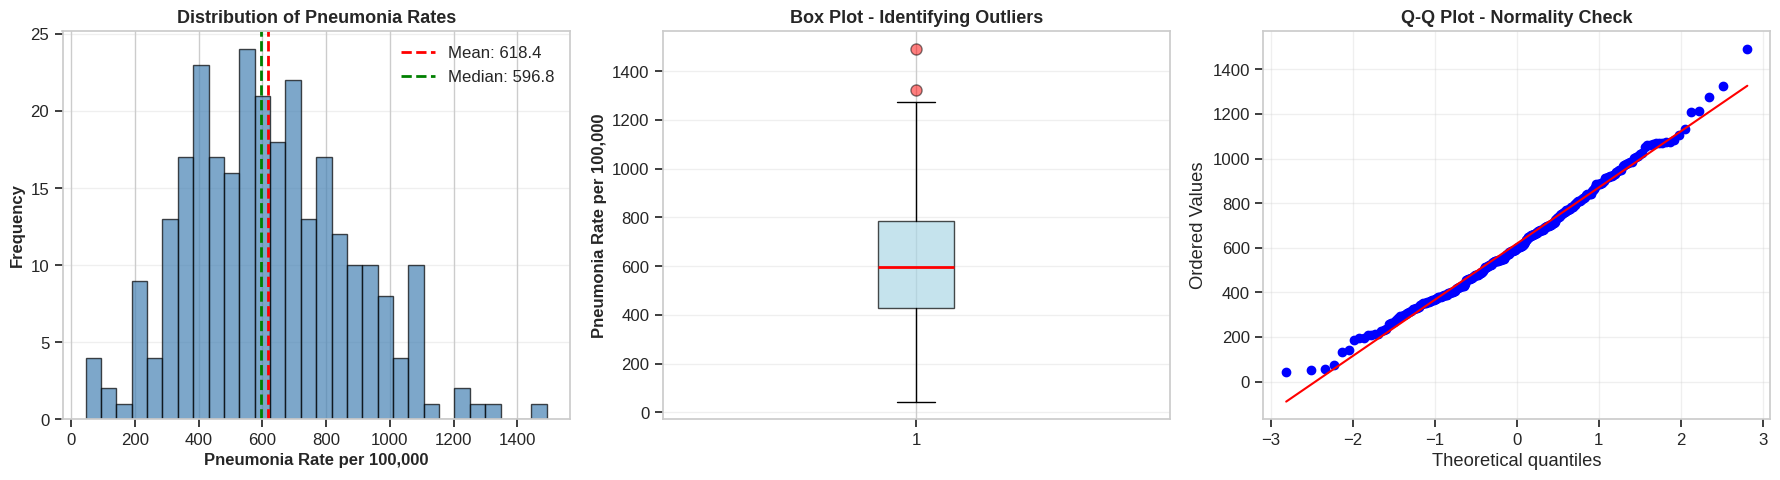

✓ Figure: Target Variable Distribution


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(pneumonia_data[target_col], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(pneumonia_data[target_col].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {pneumonia_data[target_col].mean():.1f}')
axes[0].axvline(pneumonia_data[target_col].median(), color='green', linestyle='--', linewidth=2,
                label=f'Median: {pneumonia_data[target_col].median():.1f}')
axes[0].set_xlabel('Pneumonia Rate per 100,000', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Pneumonia Rates', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot
bp = axes[1].boxplot(pneumonia_data[target_col], vert=True, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     flierprops=dict(marker='o', markerfacecolor='red', markersize=8, alpha=0.5))
axes[1].set_ylabel('Pneumonia Rate per 100,000', fontsize=12, fontweight='bold')
axes[1].set_title('Box Plot - Identifying Outliers', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Q-Q plot
stats.probplot(pneumonia_data[target_col], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot - Normality Check', fontsize=13, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Figure: Target Variable Distribution")